# Twitter Data Analysis

This notebook is dedicated to analyzing Twitter data, leveraging the power of Apache Spark, particularly PySpark, for processing and analyzing large datasets. With a focus on efficient data preparation, the notebook utilizes a custom class named DataPrep. This class offers key functionalities for manipulating and transforming Spark DataFrames, facilitating the handling of complex data structures and conducting detailed analyses.

In [1]:
%load_ext memory_profiler

In [2]:
from pyspark.sql import SparkSession

spark = SparkSession.builder.master('spark://spark-master:7077').appName("TweetStatsHub").getOrCreate()

23/12/02 16:44:00 WARN SparkSession: Using an existing Spark session; only runtime SQL configurations will take effect.


---

## DataPrep Class
---

The `DataPrep` class contains functions that are essential for preparing and manipulating data within a PySpark DataFrame. These functions streamline the process of transforming complex data structures into a more manageable format for analysis. The class now includes the following functions:

1. **`flatten_struct`**:
   - **Purpose**: Flattens a Spark DataFrame schema, transforming nested structures into a flat list of column names.
   - **How it works**: Iteratively processes each field in the schema. If a field is of type `StructType`, it is recursively flattened, and the names of the flattened fields are concatenated with a separator (`__`).
   - **Use Case**: Ideal for dealing with complex data formats like JSON or nested structures, simplifying the DataFrame for analysis.
2. **`select_and_rename`**:
   - **Purpose**: Renames columns in a DataFrame based on a list of flattened field names.
   - **How it works**: Iterates over the flattened field names, replacing the separator (`__`) with a dot (`.`) and renaming the columns in the DataFrame.
   - **Use Case**: Useful for standardizing column names, especially after flattening nested structures, making data manipulation and querying more straightforward.
3. **`partition_by_date`**:
   - **Purpose**: Partitions a DataFrame by a formatted date string.
   - **How it works**: Formats the specified date column to 'yyyy-MM-dd' format and writes the DataFrame to a specified location, partitioned by this date column.
   - **Use Case**: Enhances the efficiency of data storage and retrieval for large datasets. Common in time-series data, facilitating filtering and analysis for specific periods.
4. **`salt`**:
   - **Purpose**: Applies salting to a specific column of a DataFrame to help evenly distribute data, especially useful in reducing data skew.
   - **How it works**: Concatenates the original column value with a randomly generated salt value (within the specified range) without using a UDF.
   - **Use Case**: Particularly effective in scenarios where certain column values are overly dominant, helping to balance data distribution across partitions.

In [3]:
from typing import List

from pyspark.sql import DataFrame, types as T
from pyspark.sql import functions as F

class DataPrep:
    FIELD_SEPARATOR: str = '__'

    @staticmethod
    def flatten_struct(schema: T.StructType, prefix: str = '') -> List[str]:
        """
        Flattens a Spark DataFrame schema, transforming nested structures into a flat list of column names.

        Args:
            schema (T.StructType): The schema of the DataFrame to be flattened.
            prefix (str, optional): A prefix to prepend to each column name. Defaults to an empty string.

        Returns:
            List[str]: A list of column names with nested structures flattened.
        """
        flat_fields: List[str] = []
        for field in schema.fields:
            col_name: str = f'{prefix}{DataPrep.FIELD_SEPARATOR}{field.name}' if prefix else field.name

            if isinstance(field.dataType, T.StructType):
                flat_fields += DataPrep.flatten_struct(field.dataType, col_name)
            else:
                flat_fields.append(col_name)

        return flat_fields

    @staticmethod
    def select_and_rename(df: DataFrame, flat_fields: List[str]) -> DataFrame:
        """
        Renames columns in a DataFrame based on a list of flat field names, replacing the separator with a dot.

        Args:
            df (DataFrame): The DataFrame whose columns need to be renamed.
            flat_fields (List[str]): A list of flat field names to be used for renaming.

        Returns:
            DataFrame: A DataFrame with columns renamed as specified in flat_fields.
        """
        for field in flat_fields:
            df = df.withColumn(field, F.col(field.replace(DataPrep.FIELD_SEPARATOR, '.')))

        return df.select(flat_fields)

    @staticmethod
    def partition_by_date(df: DataFrame, date_col: str) -> None:
        """
        Partitions a DataFrame by a formatted date string.

        Args:
            df (DataFrame): The DataFrame to be partitioned.
            date_col (str): The name of the column to be used for partitioning.

        Returns:
            None
        """
        formatted_date_col: F.Column = F.date_format(date_col, 'yyyy-MM-dd').alias('formatted_date')

        df = df.withColumn('dt', formatted_date_col)

        df.write.mode('overwrite').partitionBy('dt').parquet(
            's3a://staged/farmers-protest-tweets'
        )

    @staticmethod
    def salt(df: DataFrame, column_to_salt: str, salt_range: int) -> DataFrame:
        """
        Applies salting to a specific column of a DataFrame without using a UDF.

        Args:
            df (DataFrame): Input DataFrame.
            column_to_salt (str): Name of the column to apply salting.
            salt_range (int): Number of different salt values to be used.

        Returns:
            DataFrame with a new column containing 'salted' values.
        """
        salt_expr = F.expr(
            f"concat({column_to_salt}, '_', cast(rand()*{salt_range} as int))"
        )

        return df.withColumn(f"{column_to_salt}_salted", salt_expr)

---

## Data Partitioning

---

The provided code demonstrates the partitioning process of a large dataset of tweets using PySpark, focusing on structuring the data for efficient processing in a production setting. This approach is common in handling large datasets, especially when optimizing for query performance and resource utilization.

### Reading the Data

```python
df = spark.read.json('s3a://raw/farmers-protest-tweets-2021-2-4.json')
```
The dataset, containing tweets about the farmers' protest, is loaded from a JSON file in an S3 bucket. JSON format is commonly used for data storage but is not always optimal for query performance in big data scenarios.

### Applying Data Partitioning

```python
DataPrep.partition_by_date(df, 'date')
```
The `partition_by_date` method from the `DataPrep` class is utilized to partition the data by the `date` column. This step organizes tweets into distinct partitions based on their date, setting the stage for efficient data processing.

### Conversion to Parquet During Partitioning

As the data is partitioned by date, it's also converted from JSON to Parquet format. Parquet, a columnar storage file format, is particularly well-suited for distributed data processing systems like Hadoop and Spark. This conversion enhances the performance in several ways:
- **Optimized for Read Operations**: Parquet is designed to be efficient in both storage and read operations, particularly for complex nested data structures.
- **Reduced I/O and Storage Overhead**: Parquet's efficient data compression and encoding schemes significantly reduce the data's storage footprint and I/O overhead.
- **Better Performance in Distributed Environments**: Due to its columnar format, Parquet allows for more efficient data partitioning and retrieval, which is crucial in distributed processing scenarios.

### Rationale Behind Data Partitioning

Partitioning data by date is a strategic approach in production for the following reasons:
- **Improved Query Performance**: By reducing the volume of data scanned during queries, partitioned data can drastically enhance query speed.
- **Enhanced Data Management**: Managing large datasets becomes more feasible when the data is logically organized into smaller subsets based on date.
- **Optimized Resource Utilization**: Partitioning enables more efficient parallel processing and resource allocation across a computing cluster.

In [4]:
df = spark.read.json('s3a://raw/farmers-protest-tweets-2021-2-4.json')
DataPrep.partition_by_date(df, 'date')

23/12/02 16:44:00 WARN MetricsConfig: Cannot locate configuration: tried hadoop-metrics2-s3a-file-system.properties,hadoop-metrics2.properties


---
## Data Distribution Analysis with and without Salting
---

The dataset under examination comes from tweets related to farmers' protests, stored on S3 as Parquet files. A key concern is understanding how this data is distributed over time and, specifically, whether the salting technique can optimize the performance of distributed processing in Spark.

### Initial Analysis

Initially, an analysis of the daily distribution of tweets revealed that the data volume is relatively small when distributed by date. This was evidenced by examining the number of records per day, suggesting that the data is naturally well-distributed. Therefore, there doesn't appear to be an immediate need to redistribute the data for performance improvement.

### Experimentation with Salting

Despite the initial findings, we proceeded to experiment with salting to evaluate if redistribution could indeed offer any performance advantage. To this end, salting was applied to the date column with different ranges of values (`salt_range`), and the resulting distribution was analyzed.

### Results and Interpretation of Graphs

The histogram graphs generated for each `salt_range` show the distribution of the number of records per partition. Each histogram represents a different salting configuration:

- **X-Axis**: Represents the number of records in each partition. A partition is a subset of the data that Spark processes in parallel.
- **Y-Axis**: Shows frequency, meaning how many partitions contain a specific number of records.

The results display a decreasing average and a decreasing standard deviation as we increase the `salt_range`. This indicates that by increasing the `salt_range`, we are effectively creating more partitions, but with fewer records in each.

### Conclusions

- **Low Volume per Partition**: The observation that partitions have a small volume of data suggests that the dataset is relatively small. Thus, in its current state, there isn't a significant advantage in redistributing the data with salting.
- **Partitioning Efficiency**: For data with larger volumes or for analyses over more extended periods, partitioning by date might be more effective. However, in smaller datasets or with already optimized data distribution, applying salting for redistribution might not be necessary.
- **Use Case for Salting**: In scenarios where data is unbalanced or for much larger datasets, the salting technique can be valuable to ensure an even distribution of data across partitions, optimizing parallel processing and worker efficiency.

In summary, the analysis revealed that, for this specific dataset and its data volume, partitioning by date is sufficient to ensure good performance. Salting, though a powerful technique, proves more useful in scenarios with greater complexity and data volume.

Mean: 9031.307692307691, Standard Deviation: 2290.0705733162963


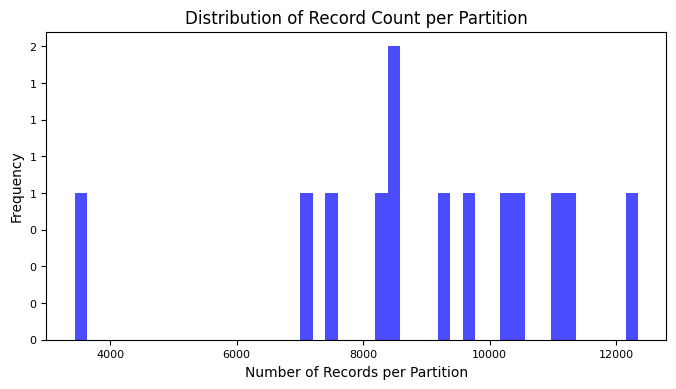

Mean: 4515.653846153846, Standard Deviation: 1122.551270715336


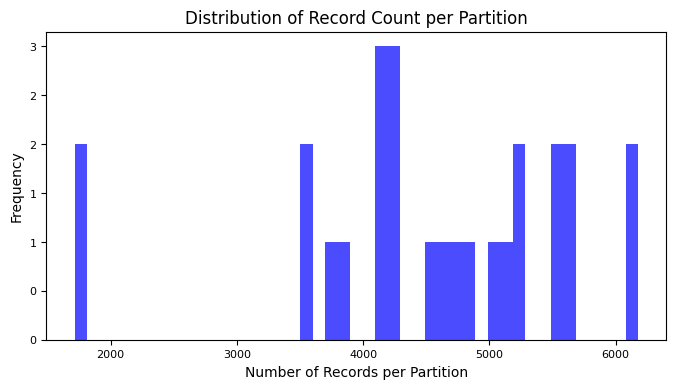

Mean: 1806.2615384615385, Standard Deviation: 445.10417590025617


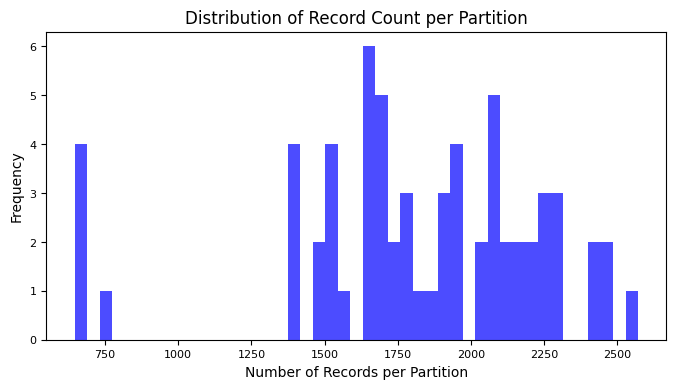

Mean: 903.1307692307693, Standard Deviation: 222.6446185689164


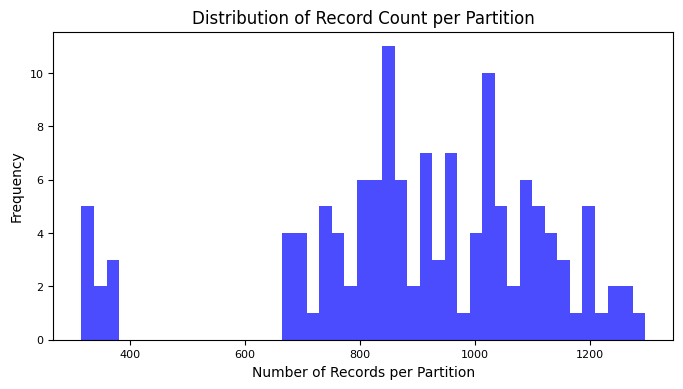

Mean: 602.0871794871795, Standard Deviation: 148.9626244887657


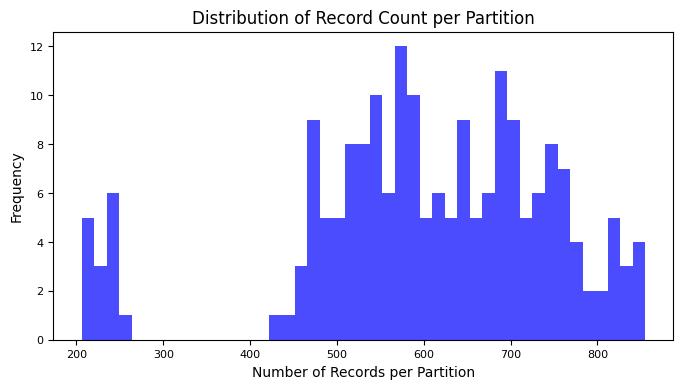

In [5]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

df = spark.read.parquet('s3a://staged/farmers-protest-tweets/')

df = df.withColumn('date', F.date_format('date', 'yyyy-MM-dd'))

for salt_range in [1, 2, 5, 10, 15]:
    salted_df = DataPrep.salt(df, 'date', salt_range)
    partition_counts = salted_df.groupBy('date_salted').count().toPandas()
    
    mean_count = partition_counts['count'].mean()
    std_dev_count = partition_counts['count'].std()
    print(f"Mean: {mean_count}, Standard Deviation: {std_dev_count}")
    
    plt.figure(figsize=(8, 4))
    plt.hist(partition_counts['count'], bins=45, color='blue', alpha=0.7)

    plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
    
    plt.title('Distribution of Record Count per Partition')
    plt.xlabel('Number of Records per Partition')
    plt.ylabel('Frequency')

    plt.xticks(fontsize=8)
    plt.yticks(fontsize=8)

    plt.show()


---
## [Q1-MEMORY] Most Active Users and Days with Highest Tweet Activity with a Focus on Memory Efficiency
---

This scenario specifically focuses on identifying the most active users and the days with the highest tweet activity, with a special emphasis on memory optimization.

### Data Preparation

The data has been preprocessed to be 'flattened', simplifying processing and reducing memory usage in operations like shuffling. This flat data structure enables more efficient computation compared to a normalized data model spread across multiple tables. While a normalized structure might be more storage-efficient, it typically results in poorer performance due to increased complexity in join operations and data shuffling.

1. The data is loaded from a Parquet file.
    ```python
    raw = spark.read.parquet(file_path)
    ```

2. The data is flattened to reduce processing overhead.
    ```python
    flattened = DataPrep.flatten_struct(raw.schema)
    ```

3. The columns are selected and renamed to optimize processing time.
    ```python
    df = DataPrep.select_and_rename(raw, flattened)
    ```

### Data Analysis

1. **Grouping Data by User and Date**:
   ```python
    active_users = df.groupBy('dt', 'user__username').count()
    ```

    Here, the `df` DataFrame is grouped by `dt` and `user__username` to count the number of tweets per user each day.

2. **Analysis Windows**:
    ```python
    total_tweets_window = Window.partitionBy('dt')
    user_rank_window = Window.partitionBy('dt').orderBy(F.desc('count'))
    ```

    We define two analysis windows:

    - `total_tweets_window`: Groups data by `dt`.

    - `user_rank_window`: Orders users within each date by the number of tweets in descending order.

3. **Ranking Users and Total Tweet Count**:
    ```python
    ranked_users = active_users.withColumn(
        'rank',
        F.rank().over(user_rank_window)
    ).withColumn(
        'tweet_count',
        F.sum('count').over(total_tweets_window)
    ).alias('ranked_users')
    ```

    Here, we add two columns to the `active_users` DataFrame:

    - `rank`: The ranking of each user based on the number of tweets per day.

    - `tweet_count`: The total number of tweets per day.

5. **Identifying Top Days by Tweet Activity**:
    ```python
    top_dates = ranked_users.select(
        F.col('dt'),
        F.col('tweet_count')
    ).distinct().orderBy(
        F.desc('tweet_count')
    ).limit(10).alias('top_dates')
    ```

    We select the 10 days with the highest tweet activity.

6. **Most Active Users per Day, Ordered by Tweet Count**:
    ```python
    top_users_per_date = ranked_users.join(
        top_dates,
        F.col('ranked_users.dt') == F.col('top_dates.dt')
    ).filter(
        F.col('rank') == 1
    ).select(
        F.col('ranked_users.dt'),
        F.col('ranked_users.user__username')
    ).orderBy(
        F.desc('top_dates.tweet_count')
    )
    ```

    Finally, we combine the information to obtain a list of the most active users for each of the top tweet activity days, ordered by the number of tweets. This provides insights into the most influential users based on their tweet frequency.

### Results

To get the memory usage, we use the `memory_profiler` package. The `%memit` magic command is used to get the memory usage of the `q1_memory` function.

```python
%memit q1_memory('s3a://staged/farmers-protest-tweets/')
```

### Considerations

1. **Analysis of Joining Intermediate Tables**: I chose to use a join between two intermediate tables, specifically `ranked_users` and `top_dates`, to address a potential scenario in Twitter activity analysis. On a peak day of Twitter activity, there may be a situation where more than one user has the highest number of tweets. To ensure that the top 10 days of tweet activity are comprehensive and accurate, it is essential not to omit any user who might have shared the position of being the most active on that day.

    The decision to not limit the analysis to a single user per day (which would be the case if we used `row_number` instead of `rank`) is made to bring clarity and completeness to the results. By doing this, we ensure that any situation where multiple users have the same amount of top tweets on a peak day is adequately represented in the final data.

    Although this approach might slightly increase the complexity and volume of data processed, it is crucial for maintaining the integrity and accuracy of the analysis. This is especially important in a dynamic and variable context like Twitter, where patterns of activity can change rapidly. Thus, this strategy ensures that our analysis is not only efficient in terms of memory but also robust and representative of actual Twitter usage patterns.

2. **Data Preprocessing and Efficiency**: The data is preprocessed to flatten the data structure and reduce processing overhead. This enables more efficient computation compared to a normalized data model spread across multiple tables. While a normalized structure might be more storage-efficient, it typically results in poorer performance due to increased complexity in join operations and data shuffling.

3. **Early Filtering for Real-world Applications**: In real-world applications, we would typically filter the data early on to reduce the amount of data to be processed. For example, we could filter the data to only include tweets from verified users, or only include tweets with a certain number of likes or retweets. This would reduce the amount of data to be processed, and would also reduce the amount of data to be shuffled during the join operations.

4. **Memory Usage**: While the memory usage is measured using the `memory_profiler` package and the `%memit` magic command, it's important to note that this measurement might not reflect the actual memory usage in a real-world Spark cluster environment. The memory usage indicated by the `memory_profiler` in a local or test environment may differ from the memory usage in a distributed Spark cluster.

    In a Spark cluster, memory usage can be affected by various factors like data distribution, cluster configuration, and the nature of the operations performed. Therefore, for a more accurate understanding of memory usage in a Spark cluster, tools like Ganglia or similar monitoring systems should be employed. These tools provide insights into the memory usage across different nodes of the cluster and help in identifying any bottlenecks or inefficiencies.

    This distinction is crucial for scaling the application and ensuring that it performs optimally in a production environment. Understanding the limitations of local memory usage measurements and the need for specialized tools in a distributed setting is key for accurate resource planning and performance optimization in large-scale data processing tasks.

    To analyze memory usage more closely to reality in a Spark environment, Ganglia can be used in the development environment that is part of this project. Simply access `localhost:8099/ganglia`, navigate to the `SparkCluster` cluster, and then to the node `twitter-data-analysis-jupyter-notebook-1.twitter-data-analysis_default`. Within the Metric Group `app-<sparkappnumber>-0000.driver.ExecutorMetrics`, you can find detailed information about memory usage of the driver's executor. This only enables analysis of the metrics of the executor for the driver. To analyze the memory usage of the worker nodes, you should navigate within `SparkCluster` to the node `twitter-data-analysis-spark-worker-1.twitter-data-analysis_default`. There, you will find a similar metric group for the executors on the worker nodes. This approach offers a more realistic view of memory consumption within both the driver and worker nodes in the Spark environment, allowing for a better assessment and optimization of the application's memory requirements.

In [6]:
from datetime import datetime
from typing import List, Tuple

from pyspark.sql import functions as F
from pyspark.sql.window import Window

def q1_memory(file_path: str) -> List[Tuple[datetime.date, str]]:
    raw = spark.read.parquet(file_path)

    flattened = DataPrep.flatten_struct(raw.schema)

    df = DataPrep.select_and_rename(raw, flattened)

    active_users = df.groupBy('dt', 'user__username').count()

    total_tweets_window = Window.partitionBy('dt')
    user_rank_window = Window.partitionBy('dt').orderBy(F.desc('count'))

    ranked_users = active_users.withColumn(
        'rank',
        F.rank().over(user_rank_window)
    ).withColumn(
        'tweet_count',
        F.sum('count').over(total_tweets_window)
    ).alias('ranked_users')

    top_dates = ranked_users.select(
        F.col('dt'),
        F.col('tweet_count')
    ).distinct().orderBy(
        F.desc('tweet_count')
    ).limit(10).alias('top_dates')

    top_users_per_date = ranked_users.join(
        top_dates,
        F.col('ranked_users.dt') == F.col('top_dates.dt')
    ).filter(
        F.col('rank') == 1
    ).select(
        F.col('ranked_users.dt'),
        F.col('ranked_users.user__username')
    ).orderBy(
        F.desc('top_dates.tweet_count')
    )

    result_data = top_users_per_date.collect()

    result = [(row['dt'], row['user__username']) for row in result_data]

    return result

%memit q1_memory('s3a://staged/farmers-protest-tweets/')

peak memory: 159.40 MiB, increment: 0.00 MiB


---
## [Q1-TIME] Most Active Users and Days with Highest Tweet Activity with a Focus on Time Processing Efficiency
---

This scenario specifically focuses on identifying the most active users and the days with the highest tweet activity, with a special emphasis on time processing efficiency.

### Data Preparation

The data has been preprocessed to be 'flattened', simplifying processing and reducing memory usage in operations like shuffling. This flat data structure enables more efficient computation compared to a normalized data model spread across multiple tables. While a normalized structure might be more storage-efficient, it typically results in poorer performance due to increased complexity in join operations and data shuffling.

1. The data is loaded from a Parquet file.
    ```python
    raw = spark.read.parquet(file_path)
    ```

2. The data is flattened to reduce processing overhead.
    ```python
    flattened = DataPrep.flatten_struct(raw.schema)
    ```

3. The columns are selected and renamed to optimize processing time.
    ```python
    df = DataPrep.select_and_rename(raw, flattened)
    ```

### Data Analysis

1. **Grouping Data by User and Date**:
    ```python
    active_users = df.groupBy('dt', 'user__username').count()
    ```

    Here, the `df` DataFrame is grouped by `dt` and `user__username` to count the number of tweets per user each day.

2. **Analysis Windows**:
    ```python
    total_tweets_window = Window.partitionBy('dt')
    user_rank_window = Window.partitionBy('dt').orderBy(F.desc('count'))
    ```

    We define two analysis windows:

    - `total_tweets_window`: Groups data by `dt`.

    - `user_rank_window`: Orders users within each date by the number of tweets in descending order.

4. **Ranking Users and Total Tweet Count**:
    ```python
    ranked_users = active_users.withColumn(
        'rank',
        F.rank().over(user_rank_window)
    ).withColumn(
        'tweet_count',
        F.sum('count').over(total_tweets_window)
    ).alias('ranked_users').cache()
    ```

    Here, we add two columns to the `active_users` DataFrame:

    - `rank`: The ranking of each user based on the number of tweets per day.
  
    - `tweet_count`: The total number of tweets per day.

    Incorporating `rank` and `tweet_count` columns, with caching to retain intermediate results in memory.

6. **Identifying Top Days by Tweet Activity**:
    ```python
    top_dates = ranked_users.select(
        F.col('dt'),
        F.col('tweet_count')
    ).distinct().orderBy(
        F.desc('tweet_count')
    ).limit(10).alias('top_dates')
    ```

    We select the 10 days with the highest tweet activity.

7. **Most Active Users per Day, Ordered by Tweet Count**:
    ```python
    top_users_per_date = ranked_users.join(
        F.broadcast(top_dates),
        F.col('ranked_users.dt') == F.col('top_dates.dt')
    ).filter(
        F.col('rank') == 1
    ).select(
        F.col('ranked_users.dt'),
        F.col('ranked_users.user__username')
    ).orderBy(
        F.desc('top_dates.tweet_count')
    ).repartition("dt")
    ```

    Utilizing `broadcast()` for efficient joins and reparitioning the data by `dt` to reduce shuffling.

    Finally, we combine the information to obtain a list of the most active users for each of the top tweet activity days, ordered by the number of tweets. This provides insights into the most influential users based on their tweet frequency.

### Results

To get the time taken for the analysis, we use the `%timeit` magic command. The `%timeit` magic command runs the code multiple times and returns the average time taken.

```python
%timeit q1_time('s3a://staged/farmers-protest-tweets/')
```

### Considerations

1. **Analysis of Joining Intermediate Tables**: I chose to use a join between two intermediate tables, specifically `ranked_users` and `top_dates`, to address a potential scenario in Twitter activity analysis. On a peak day of Twitter activity, there may be a situation where more than one user has the highest number of tweets. To ensure that the top 10 days of tweet activity are comprehensive and accurate, it is essential not to omit any user who might have shared the position of being the most active on that day.

    The decision to not limit the analysis to a single user per day (which would be the case if we used `row_number` instead of `rank`) is made to bring clarity and completeness to the results. By doing this, we ensure that any situation where multiple users have the same amount of top tweets on a peak day is adequately represented in the final data.

    Although this approach might slightly increase the complexity and volume of data processed, it is crucial for maintaining the integrity and accuracy of the analysis. This is especially important in a dynamic and variable context like Twitter, where patterns of activity can change rapidly. Thus, this strategy ensures that our analysis is not only efficient in terms of memory but also robust and representative of actual Twitter usage patterns.

1. **Cluster and Resource**: The optimizations employed here, such as caching and broadcast joins, are most effective in a cluster with multiple workers and high memory capacity. Running this code on a standalone cluster or a cluster with limited memory may not yield significant time efficiency gains.

2. **Data Preprocessing and Efficiency**: The data is preprocessed to flatten the data structure and reduce processing overhead. This enables more efficient computation compared to a normalized data model spread across multiple tables. While a normalized structure might be more storage-efficient, it typically results in poorer performance due to increased complexity in join operations and data shuffling.

3. **Early Filtering for Real-world Applications**: In real-world applications, we would typically filter the data early on to reduce the amount of data to be processed. For example, we could filter the data to only include tweets from verified users, or only include tweets with a certain number of likes or retweets. This would reduce the amount of data to be processed, and would also reduce the amount of data to be shuffled during the join operations.

4. **Memory Constraints with Repeated `%timeit` Execution**: When repeatedly testing the same code using `%timeit`, there's a risk of encountering Java memory shortages. This is particularly relevant because `%timeit` executes the code multiple times to calculate the average runtime. In such cases, re-executing the code might be necessary to obtain the expected results. This consideration is crucial for maintaining the stability and reliability of the analysis process, particularly in environments with limited memory resources.

5. **Real-world Cluster Time Measurement Limitations**: The `%timeit` command, while effective within the Jupyter Notebook context, does not capture the full scope of time consumption in a Spark cluster environment. To gain a more comprehensive understanding of the time efficiency, it's essential to access the Ganglia monitoring interface at `localhost:8099`. This interface provides insights into the memory and processing time used by different components of the `SparkCluster`, such as `twitter-data-analysis-spark-master-1.twitter-data-analysis_default`, `twitter-data-analysis-spark-worker-1.twitter-data-analysis_default`, and the local driver node `twitter-data-analysis-jupyter-notebook-1.twitter-data-analysis_default`. Monitoring these nodes can offer a more accurate depiction of the overall resource utilization and processing time, reflecting the true efficiency of the data analysis in a distributed computing environment.

In [5]:
from pyspark.sql.window import Window
from pyspark.sql import functions as F

def q1_time(file_path: str) -> List[Tuple[datetime.date, str]]:
    raw = spark.read.parquet(file_path)

    flattened = DataPrep.flatten_struct(raw.schema)

    df = DataPrep.select_and_rename(raw, flattened)

    active_users = df.groupBy('dt', 'user__username').count()

    total_tweets_window = Window.partitionBy('dt')
    user_rank_window = Window.partitionBy('dt').orderBy(F.desc('count'))

    ranked_users = active_users.withColumn(
        'rank',
        F.rank().over(user_rank_window)
    ).withColumn(
        'tweet_count',
        F.sum('count').over(total_tweets_window)
    ).alias('ranked_users').cache()

    top_dates = ranked_users.select(
        F.col('dt'),
        F.col('tweet_count')
    ).distinct().orderBy(
        F.desc('tweet_count')
    ).limit(10).alias('top_dates')

    top_users_per_date = ranked_users.join(
        F.broadcast(top_dates),
        F.col('ranked_users.dt') == F.col('top_dates.dt')
    ).filter(
        F.col('rank') == 1
    ).select(
        F.col('ranked_users.dt'),
        F.col('ranked_users.user__username')
    ).orderBy(
        F.desc('top_dates.tweet_count')
    ).repartition("dt")

    return top_users_per_date.collect()

%timeit q1_time('s3a://staged/farmers-protest-tweets/')

23/12/02 09:44:46 WARN CacheManager: Asked to cache already cached data.


23/12/02 09:44:57 WARN CacheManager: Asked to cache already cached data.


23/12/02 09:45:07 WARN CacheManager: Asked to cache already cached data.


23/12/02 09:45:17 WARN CacheManager: Asked to cache already cached data.


23/12/02 09:45:28 WARN CacheManager: Asked to cache already cached data.


23/12/02 09:45:38 WARN CacheManager: Asked to cache already cached data.


23/12/02 09:45:49 WARN CacheManager: Asked to cache already cached data.


10.4 s ± 302 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


---
## [Q2-MEMORY] Emoji Usage in Tweets with a Focus on Memory Efficiency
---

This code demonstrates a approach for analyzing emoji usage in tweets, with a focus on memory efficiency, and a detailed understanding of Unicode ranges for emojis.

### Data Preparation

The data has been preprocessed to be 'flattened', simplifying processing and reducing memory usage in operations like shuffling. This flat data structure enables more efficient computation compared to a normalized data model spread across multiple tables. While a normalized structure might be more storage-efficient, it typically results in poorer performance due to increased complexity in join operations and data shuffling.

1. The data is loaded from a Parquet file.
    ```python
    raw = spark.read.parquet(file_path)
    ```

2. The data is flattened to reduce processing overhead.
    ```python
    flattened = DataPrep.flatten_struct(raw.schema)
    ```

3. The columns are selected and renamed to optimize processing time.
    ```python
    df = DataPrep.select_and_rename(raw, flattened)
    ```

### Data Analysis

1. **Unicode Ranges and Their Meanings**:

    The regex pattern for emojis spans several Unicode ranges, each representing different types of emojis:

    1. **Regional Indicator Symbols (`\U0001F1E0-\U0001F1FF`)**: Used to encode flag symbols. Each symbol represents a country code, and a pair of these create flag emojis.

    2. **Miscellaneous Symbols and Pictographs (`\U0001F300-\U0001F5FF`)**: Includes a wide array of symbols and images, such as weather icons and common objects.

    3. **Emoticons (`\U0001F600-\U0001F64F`)**: Dedicated to classic smiley faces and other emotion-representing faces.

    4. **Transport and Map Symbols (`\U0001F680-\U0001F6FF`)**: This category includes various modes of transportation, like cars and trains, and symbols used in maps.

    5. **Alchemical Symbols (`\U0001F700-\U0001F77F`)**: Includes symbols from ancient alchemy manuscripts.

    6. **Geometric Shapes Extended (`\U0001F780-\U0001F7FF`)**: A variety of geometric shapes used for various purposes.

    7. **Supplemental Arrows-C (`\U0001F800-\U0001F8FF`)**: A collection of arrows of different types and orientations.

    8. **Supplemental Symbols and Pictographs (`\U0001F900-\U0001F9FF`)**: A variety of symbols and pictures, including emojis for activities and professions.

    9. **Chess Symbols (`\U0001FA00-\U0001FA6F`)**: As the name suggests, includes symbols related to the game of chess.

    10. **Symbols and Pictographs Extended-A (`\U0001FA70-\U0001FAFF`)**: An extension range that includes additional symbols and pictographs.

    11. **Dingbats (`\U00002702-\U000027B0`)**: Consists of decorative markers and miscellaneous symbols.

    12. **Enclosed Characters (`\U000024C2-\U0001F251`)**: Typically circles or squares containing alphanumeric characters or simple images.

3. **Hybrid Approach for Emoji Extraction: Regex and Demoji**:
    ```python
   emoji_pattern = r'[\U0001F1E0-\U0001F1FF\U0001F300-\U0001F5FF\U0001F600-\U0001F64F\U0001F680-\U0001F6FF\U0001F700-\U0001F77F\U0001F780-\U0001F7FF\U0001F800-\U0001F8FF\U0001F900-\U0001F9FF\U0001FA00-\U0001FA6F\U0001FA70-\U0001FAFF\U00002702-\U000027B0\U000024C2-\U0001F251]+'
   ```

   The regex pattern is designed to quickly sift through text and identify character sequences that potentially represent emojis, thus reducing the dataset before the more resource-intensive `demoji` analysis.

4. **Accurate Emoji Extraction with Demoji**:
    ```python
   @F.udf(returnType=T.ArrayType(T.StringType()))
   def extract_emojis(text):
       potential_emojis = re.findall(emoji_pattern, text)
       emojis = []

       for emoji in potential_emojis:
           extracted = demoji.findall(emoji)
           emojis.extend(extracted.keys())

       return emojis

   emojis_df = df.withColumn('emojis', extract_emojis(F.col('content')))
   ```

   `demoji` is then used on the filtered text to accurately extract and identify the emojis. This two-step process significantly speeds up the emoji extraction as `demoji` operates only on strings likely to contain emojis, rather than scanning every character in the text.

5. **Aggregation and Analysis**:
    ```python
    emojis_flat = emojis_df.withColumn('emoji', F.explode('emojis'))

    emojis_count = emojis_flat.groupBy('emoji').count()

    top_10_emojis = emojis_count.orderBy(F.col('count').desc()).limit(10)

    result_data = top_10_emojis.collect()

    result = [(row['emoji'], row['count']) for row in result_data]
    ```

    This section aggregates and analyzes emoji data, emphasizing both memory and speed efficiency.

### Results

To get the memory usage, we use the `memory_profiler` package. The `%memit` magic command is used to get the memory usage of the `q2_memory` function.

```python
%memit q2_memory('s3a://staged/farmers-protest-tweets/')
```

### Considerations

1. **Scalability and Adaptability**: This methodology, focusing on memory efficiency and processing speed, is highly scalable and adaptable to various dataset sizes and computational resources. It's particularly suitable for large-scale data analysis where memory constraints and processing time are significant concerns. The hybrid approach of using regex and `demoji` proves to be more efficient than using `demoji` alone, making it a robust solution for real-world applications.

2. **Data Preprocessing and Efficiency**: The data is preprocessed to flatten the data structure and reduce processing overhead. This enables more efficient computation compared to a normalized data model spread across multiple tables. While a normalized structure might be more storage-efficient, it typically results in poorer performance due to increased complexity in join operations and data shuffling.

3. **Early Filtering for Real-world Applications**: In real-world applications, we would typically filter the data early on to reduce the amount of data to be processed. For example, we could filter the data to only include tweets from verified users, or only include tweets with a certain number of likes or retweets. This would reduce the amount of data to be processed, and would also reduce the amount of data to be shuffled during the join operations.

4. **Memory Usage**: While the memory usage is measured using the `memory_profiler` package and the `%memit` magic command, it's important to note that this measurement might not reflect the actual memory usage in a real-world Spark cluster environment. The memory usage indicated by the `memory_profiler` in a local or test environment may differ from the memory usage in a distributed Spark cluster.

    In a Spark cluster, memory usage can be affected by various factors like data distribution, cluster configuration, and the nature of the operations performed. Therefore, for a more accurate understanding of memory usage in a Spark cluster, tools like Ganglia or similar monitoring systems should be employed. These tools provide insights into the memory usage across different nodes of the cluster and help in identifying any bottlenecks or inefficiencies.

    This distinction is crucial for scaling the application and ensuring that it performs optimally in a production environment. Understanding the limitations of local memory usage measurements and the need for specialized tools in a distributed setting is key for accurate resource planning and performance optimization in large-scale data processing tasks.

    To analyze memory usage more closely to reality in a Spark environment, Ganglia can be used in the development environment that is part of this project. Simply access `localhost:8099/ganglia`, navigate to the `SparkCluster` cluster, and then to the node `twitter-data-analysis-jupyter-notebook-1.twitter-data-analysis_default`. Within the Metric Group `app-<sparkappnumber>-0000.driver.ExecutorMetrics`, you can find detailed information about memory usage of the driver's executor. This only enables analysis of the metrics of the executor for the driver. To analyze the memory usage of the worker nodes, you should navigate within `SparkCluster` to the node `twitter-data-analysis-spark-worker-1.twitter-data-analysis_default`. There, you will find a similar metric group for the executors on the worker nodes. This approach offers a more realistic view of memory consumption within both the driver and worker nodes in the Spark environment, allowing for a better assessment and optimization of the application's memory requirements.

In [9]:
import re
import demoji
from typing import List, Tuple

from pyspark.sql import types as T
from pyspark.sql import functions as F

def q2_memory(file_path: str) -> List[Tuple[str, int]]:
    emoji_pattern = r'[\U0001F1E0-\U0001F1FF\U0001F300-\U0001F5FF\U0001F600-\U0001F64F\U0001F680-\U0001F6FF\U0001F700-\U0001F77F\U0001F780-\U0001F7FF\U0001F800-\U0001F8FF\U0001F900-\U0001F9FF\U0001FA00-\U0001FA6F\U0001FA70-\U0001FAFF\U00002702-\U000027B0\U000024C2-\U0001F251]+'

    raw = spark.read.parquet(file_path)

    flattened = DataPrep.flatten_struct(raw.schema)

    df = DataPrep.select_and_rename(raw, flattened)

    @F.udf(returnType=T.ArrayType(T.StringType()))
    def extract_emojis(text):
        potential_emojis = re.findall(emoji_pattern, text)
        emojis = []

        for emoji in potential_emojis:
            extracted = demoji.findall(emoji)
            emojis.extend(extracted.keys())

        return emojis

    emojis_df = df.withColumn('emojis', extract_emojis(F.col('content')))
    emojis_flat = emojis_df.withColumn('emoji', F.explode('emojis'))

    emojis_count = emojis_flat.groupBy('emoji').count()

    top_10_emojis = emojis_count.orderBy(F.col('count').desc()).limit(10)

    result_data = top_10_emojis.collect()

    result = [(row['emoji'], row['count']) for row in result_data]

    return result

%memit q2_memory('s3a://staged/farmers-protest-tweets/')

peak memory: 172.27 MiB, increment: 0.00 MiB


---
## [Q2-TIME] Emoji Usage in Tweets with a Focus on Time Processing Efficiency
---

This code demonstrates a approach for analyzing emoji usage in tweets, with a focus on time processing efficiency, and a detailed understanding of Unicode ranges for emojis.

### Data Preparation

The data has been preprocessed to be 'flattened', simplifying processing and reducing memory usage in operations like shuffling. This flat data structure enables more efficient computation compared to a normalized data model spread across multiple tables. While a normalized structure might be more storage-efficient, it typically results in poorer performance due to increased complexity in join operations and data shuffling.

1. The data is loaded from a Parquet file.
    ```python
    raw = spark.read.parquet(file_path)
    ```

2. The data is flattened to reduce processing overhead.
    ```python
    flattened = DataPrep.flatten_struct(raw.schema)
    ```

3. The columns are selected and renamed to optimize processing time.
    ```python
    df = DataPrep.select_and_rename(raw, flattened)
    ```

### Data Analysis

1. **Unicode Ranges and Their Meanings**:
    The regex pattern for emojis spans several Unicode ranges, each representing different types of emojis:

    1. **Regional Indicator Symbols (`\U0001F1E0-\U0001F1FF`)**: Used to encode flag symbols. Each symbol represents a country code, and a pair of these create flag emojis.

    2. **Miscellaneous Symbols and Pictographs (`\U0001F300-\U0001F5FF`)**: Includes a wide array of symbols and images, such as weather icons and common objects.

    3. **Emoticons (`\U0001F600-\U0001F64F`)**: Dedicated to classic smiley faces and other emotion-representing faces.

    4. **Transport and Map Symbols (`\U0001F680-\U0001F6FF`)**: This category includes various modes of transportation, like cars and trains, and symbols used in maps.

    5. **Alchemical Symbols (`\U0001F700-\U0001F77F`)**: Includes symbols from ancient alchemy manuscripts.

    6. **Geometric Shapes Extended (`\U0001F780-\U0001F7FF`)**: A variety of geometric shapes used for various purposes.

    7. **Supplemental Arrows-C (`\U0001F800-\U0001F8FF`)**: A collection of arrows of different types and orientations.

    8. **Supplemental Symbols and Pictographs (`\U0001F900-\U0001F9FF`)**: A variety of symbols and pictures, including emojis for activities and professions.

    9. **Chess Symbols (`\U0001FA00-\U0001FA6F`)**: As the name suggests, includes symbols related to the game of chess.

    10. **Symbols and Pictographs Extended-A (`\U0001FA70-\U0001FAFF`)**: An extension range that includes additional symbols and pictographs.

    11. **Dingbats (`\U00002702-\U000027B0`)**: Consists of decorative markers and miscellaneous symbols.

    12. **Enclosed Characters (`\U000024C2-\U0001F251`)**: Typically circles or squares containing alphanumeric characters or simple images.

2. **Transition to Pandas UDF: Performance versus Memory Trade-Offs**:
    ```python
    @F.pandas_udf(T.ArrayType(T.StringType()))
    def extract_emojis(texts: pd.Series) -> pd.Series:
        # ...

    emojis_df = df.withColumn('emojis', extract_emojis(F.col('content')))
    ```

    The switch to `pandas_udf` from a regular UDF offers significant performance improvements due to its vectorized operations, which process data in batches rather than row by row. This results in faster execution times. However, it's important to note that `pandas_udf` can potentially increase memory usage, as it requires fitting the data of a single group into the memory of one worker node during operations. This necessitates careful memory management, especially when dealing with large datasets.


3. **Hybrid Approach for Emoji Extraction: Regex and Demoji**:
    ```python
   emoji_pattern = r'[\U0001F1E0-\U0001F1FF\U0001F300-\U0001F5FF\U0001F600-\U0001F64F\U0001F680-\U0001F6FF\U0001F700-\U0001F77F\U0001F780-\U0001F7FF\U0001F800-\U0001F8FF\U0001F900-\U0001F9FF\U0001FA00-\U0001FA6F\U0001FA70-\U0001FAFF\U00002702-\U000027B0\U000024C2-\U0001F251]+'
   ```

   The regex pattern is designed to quickly sift through text and identify character sequences that potentially represent emojis, thus reducing the dataset before the more resource-intensive `demoji` analysis.

4. **Accurate Emoji Extraction with Demoji**:
    ```python
   @F.udf(returnType=T.ArrayType(T.StringType()))
   def extract_emojis(text):
       potential_emojis = re.findall(emoji_pattern, text)
       emojis = []

       for emoji in potential_emojis:
           extracted = demoji.findall(emoji)
           emojis.extend(extracted.keys())

       return emojis

   emojis_df = df.withColumn('emojis', extract_emojis(F.col('content')))
   ```

   `demoji` is then used on the filtered text to accurately extract and identify the emojis. This two-step process significantly speeds up the emoji extraction as `demoji` operates only on strings likely to contain emojis, rather than scanning every character in the text.

4. **Aggregation and Analysis**:
    ```python
    emojis_df.cache()

    emojis_flat = emojis_df.withColumn('emoji', F.explode('emojis')).repartition("emoji")

    emojis_count = emojis_flat.groupBy('emoji').count()

    top_10_emojis = emojis_count.orderBy(F.col('count').desc()).limit(10)

    result_data = top_10_emojis.collect()

    result = [(row['emoji'], row['count']) for row in result_data]
    ```

    This section emphasizes the efficiency of aggregation and analysis. The use of `.cache()` is a strategic choice to improve processing time by keeping intermediate results in memory, thus speeding up subsequent access to this data. It's a balance between memory usage and processing efficiency.

### Results

To get the time taken for the analysis, we use the `%timeit` magic command. The `%timeit` magic command runs the code multiple times and returns the average time taken.

```python
%timeit q2_time('s3a://staged/farmers-protest-tweets/')
```

### Considerations

1. **Scalability and Adaptability**: This methodology, focusing on time processing efficiency and careful memory management, is highly scalable and adaptable to various dataset sizes and computational resources. The use of caching and the hybrid approach of regex and `demoji` improve efficiency. However, it's important to monitor memory usage, especially in operations involving large datasets, to avoid memory overflow issues. This approach is particularly suitable for large-scale data analysis where processing time constraints and memory efficiency are critical considerations.

2. **Cluster and Resource**: The optimizations employed here, such as caching and broadcast joins, are most effective in a cluster with multiple workers and high memory capacity. Running this code on a standalone cluster or a cluster with limited memory may not yield significant time efficiency gains.

3. **Data Preprocessing and Efficiency**: The data is preprocessed to flatten the data structure and reduce processing overhead. This enables more efficient computation compared to a normalized data model spread across multiple tables. While a normalized structure might be more storage-efficient, it typically results in poorer performance due to increased complexity in join operations and data shuffling.

4. **Early Filtering for Real-world Applications**: In real-world applications, we would typically filter the data early on to reduce the amount of data to be processed. For example, we could filter the data to only include tweets from verified users, or only include tweets with a certain number of likes or retweets. This would reduce the amount of data to be processed, and would also reduce the amount of data to be shuffled during the join operations.

5. **Memory Constraints with Repeated `%timeit` Execution**: When repeatedly testing the same code using `%timeit`, there's a risk of encountering Java memory shortages. This is particularly relevant because `%timeit` executes the code multiple times to calculate the average runtime. In such cases, re-executing the code might be necessary to obtain the expected results. This consideration is crucial for maintaining the stability and reliability of the analysis process, particularly in environments with limited memory resources.

6. **Real-world Cluster Time Measurement Limitations**: The `%timeit` command, while effective within the Jupyter Notebook context, does not capture the full scope of time consumption in a Spark cluster environment. To gain a more comprehensive understanding of the time efficiency, it's essential to access the Ganglia monitoring interface at `localhost:8099`. This interface provides insights into the memory and processing time used by different components of the `SparkCluster`, such as `twitter-data-analysis-spark-master-1.twitter-data-analysis_default`, `twitter-data-analysis-spark-worker-1.twitter-data-analysis_default`, and the local driver node `twitter-data-analysis-jupyter-notebook-1.twitter-data-analysis_default`. Monitoring these nodes can offer a more accurate depiction of the overall resource utilization and processing time, reflecting the true efficiency of the data analysis in a distributed computing environment.

In [6]:
import re
import demoji
import pandas as pd
from typing import List, Tuple

from pyspark.sql import types as T
from pyspark.sql import functions as F

def q2_time(file_path: str) -> List[Tuple[str, int]]:
    emoji_pattern = r'[\U0001F1E0-\U0001F1FF\U0001F300-\U0001F5FF\U0001F600-\U0001F64F\U0001F680-\U0001F6FF\U0001F700-\U0001F77F\U0001F780-\U0001F7FF\U0001F800-\U0001F8FF\U0001F900-\U0001F9FF\U0001FA00-\U0001FA6F\U0001FA70-\U0001FAFF\U00002702-\U000027B0\U000024C2-\U0001F251]+'

    raw = spark.read.parquet(file_path)

    flattened = DataPrep.flatten_struct(raw.schema)

    df = DataPrep.select_and_rename(raw, flattened)

    @F.pandas_udf(T.ArrayType(T.StringType()))
    def extract_emojis(texts: pd.Series) -> pd.Series:
        def extract(text):
            potential_emojis = re.findall(emoji_pattern, text)
            emojis = []

            for emoji in potential_emojis:
                extracted = demoji.findall(emoji)
                emojis.extend(extracted.keys())
            return emojis

        return texts.apply(extract)

    emojis_df = df.withColumn('emojis', extract_emojis(F.col('content')))

    emojis_df.cache()

    emojis_flat = emojis_df.withColumn('emoji', F.explode('emojis')).repartition("emoji")

    emojis_count = emojis_flat.groupBy('emoji').count()

    top_10_emojis = emojis_count.orderBy(F.col('count').desc()).limit(10)

    result_data = top_10_emojis.collect()

    result = [(row['emoji'], row['count']) for row in result_data]

    return result

%timeit q2_time('s3a://staged/farmers-protest-tweets/')

23/12/02 09:46:59 WARN package: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


23/12/02 09:47:12 WARN CacheManager: Asked to cache already cached data.


23/12/02 09:47:20 WARN CacheManager: Asked to cache already cached data.
23/12/02 09:47:27 WARN CacheManager: Asked to cache already cached data.
23/12/02 09:47:35 WARN CacheManager: Asked to cache already cached data.
23/12/02 09:47:43 WARN CacheManager: Asked to cache already cached data.
23/12/02 09:47:50 WARN CacheManager: Asked to cache already cached data.
23/12/02 09:47:58 WARN CacheManager: Asked to cache already cached data.
7.57 s ± 253 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


---
## [Q3-MEMORY] Identifying Top 10 Influential Twitter Users Based on Mentions with a Focus on Memory Efficiency
---

This code demonstrates a approach for identifying the top 10 influential Twitter users based on mentions, with a focus on memory efficiency, and a detailed understanding of memory management and optimization.

### Data Preparation

The data has been preprocessed to be 'flattened', simplifying processing and reducing memory usage in operations like shuffling. This flat data structure enables more efficient computation compared to a normalized data model spread across multiple tables. While a normalized structure might be more storage-efficient, it typically results in poorer performance due to increased complexity in join operations and data shuffling.

1. The data is loaded from a Parquet file.
    ```python
    raw = spark.read.parquet(file_path)
    ```

2. The data is flattened to reduce processing overhead.
    ```python
    flattened = DataPrep.flatten_struct(raw.schema)
    ```

3. The columns are selected and renamed to optimize processing time.
    ```python
    df = DataPrep.select_and_rename(raw, flattened)
    ```

### Data Analysis

1. **Exploding 'mentionedUsers' Column**:
   ```python
   tweets_df_with_mentions = df.select('*', F.explode('mentionedUsers').alias('mentioned_user'))
   ```
   The `explode` function is used here to transform each element of an array column into a separate row, effectively expanding the 'mentionedUsers' array into individual records.

2. **Grouping and Counting Mentions**:
   ```python
   top10_influential_users = tweets_df_with_mentions.groupBy('mentioned_user.username').count().orderBy('count', ascending=False).limit(10)
   ```
   The dataset is grouped by the username of the mentioned users, and the number of mentions (`count`) is calculated for each user. The data is then ordered in descending order of mention count, and the top 10 users are selected.

3. **Collecting Results**:
   ```python
   result_data = top10_influential_users.collect()
   result = [(row['username'], row['count']) for row in result_data]
   ```
   The final step involves collecting the results into a list of tuples, each containing the username and the count of mentions.

### Results

To get the memory usage, we use the `memory_profiler` package. The `%memit` magic command is used to get the memory usage of the `q3_memory` function.

```python
%memit q3_memory('s3a://staged/farmers-protest-tweets/')
```

### Considerations

1. **Data Preprocessing and Efficiency**: The data is preprocessed to flatten the data structure and reduce processing overhead. This enables more efficient computation compared to a normalized data model spread across multiple tables. While a normalized structure might be more storage-efficient, it typically results in poorer performance due to increased complexity in join operations and data shuffling.

2. **Early Filtering for Real-world Applications**: In real-world applications, we would typically filter the data early on to reduce the amount of data to be processed. For example, we could filter the data to only include tweets from verified users, or only include tweets with a certain number of likes or retweets. This would reduce the amount of data to be processed, and would also reduce the amount of data to be shuffled during the join operations.

3. **Memory Usage**: While the memory usage is measured using the `memory_profiler` package and the `%memit` magic command, it's important to note that this measurement might not reflect the actual memory usage in a real-world Spark cluster environment. The memory usage indicated by the `memory_profiler` in a local or test environment may differ from the memory usage in a distributed Spark cluster.

    In a Spark cluster, memory usage can be affected by various factors like data distribution, cluster configuration, and the nature of the operations performed. Therefore, for a more accurate understanding of memory usage in a Spark cluster, tools like Ganglia or similar monitoring systems should be employed. These tools provide insights into the memory usage across different nodes of the cluster and help in identifying any bottlenecks or inefficiencies.

    This distinction is crucial for scaling the application and ensuring that it performs optimally in a production environment. Understanding the limitations of local memory usage measurements and the need for specialized tools in a distributed setting is key for accurate resource planning and performance optimization in large-scale data processing tasks.

    To analyze memory usage more closely to reality in a Spark environment, Ganglia can be used in the development environment that is part of this project. Simply access `localhost:8099/ganglia`, navigate to the `SparkCluster` cluster, and then to the node `twitter-data-analysis-jupyter-notebook-1.twitter-data-analysis_default`. Within the Metric Group `app-<sparkappnumber>-0000.driver.ExecutorMetrics`, you can find detailed information about memory usage of the driver's executor. This only enables analysis of the metrics of the executor for the driver. To analyze the memory usage of the worker nodes, you should navigate within `SparkCluster` to the node `twitter-data-analysis-spark-worker-1.twitter-data-analysis_default`. There, you will find a similar metric group for the executors on the worker nodes. This approach offers a more realistic view of memory consumption within both the driver and worker nodes in the Spark environment, allowing for a better assessment and optimization of the application's memory requirements.

In [7]:
from typing import List, Tuple

from pyspark.sql import functions as F

def q3_memory(file_path: str) -> List[Tuple[str, int]]:
    raw = spark.read.parquet(file_path)

    flattened = DataPrep.flatten_struct(raw.schema)

    df = DataPrep.select_and_rename(raw, flattened)

    tweets_df_with_mentions = df.select(
        '*',
        F.explode('mentionedUsers').alias('mentioned_user')
    )

    top10_influential_users = tweets_df_with_mentions.groupBy(
        'mentioned_user.username'
    ).count().orderBy(
        'count',
        ascending=False
    ).limit(10)

    result_data = top10_influential_users.collect()

    result = [(row['username'], row['count']) for row in result_data]

    return result


%memit q3_memory('s3a://staged/farmers-protest-tweets/')

peak memory: 128.10 MiB, increment: 0.00 MiB


---
## [Q3-TIME] Identifying Top 10 Influential Twitter Users Based on Mentions with a Focus on Time Processing Efficiency
---

This code demonstrates a approach for identifying the top 10 influential Twitter users based on mentions, with a focus on time processing efficiency, and a detailed understanding of memory management and optimization.

### Data Preparation

The data has been preprocessed to be 'flattened', simplifying processing and reducing memory usage in operations like shuffling. This flat data structure enables more efficient computation compared to a normalized data model spread across multiple tables. While a normalized structure might be more storage-efficient, it typically results in poorer performance due to increased complexity in join operations and data shuffling.

1. The data is loaded from a Parquet file.
    ```python
    raw = spark.read.parquet(file_path)
    ```

2. The data is flattened to reduce processing overhead.
    ```python
    flattened = DataPrep.flatten_struct(raw.schema)
    ```

3. The columns are selected and renamed to optimize processing time.
    ```python
    df = DataPrep.select_and_rename(raw, flattened)
    ```

### Data Analysis

1. **Caching the Processed DataFrame**:
   ```python
   df.cache()
   ```
   Here, caching the DataFrame `df` in memory plays a crucial role. It significantly speeds up the processing time by storing the intermediate state of `df` after the initial load and transformation. This is particularly effective in reducing the computational overhead for subsequent operations on the DataFrame.

2. **Expanding and Repartitioning 'mentionedUsers'**:
   ```python
   tweets_df_with_mentions = df.withColumn('mentioned_user', F.explode('mentionedUsers')).repartition('mentioned_user')
   ```
   The `explode` function expands the 'mentionedUsers' array into individual rows. Repartitioning by 'mentioned_user' optimizes the data distribution across the cluster for subsequent groupBy operations, enhancing processing efficiency.

3. **Grouping, Counting, and Repartitioning**:
   ```python
   top10_influential_users = tweets_df_with_mentions.groupBy('mentioned_user.username').count().repartition(F.lit(1)).orderBy(F.col('count').desc()).limit(10)
   ```
   After grouping by username, a `count` operation is performed. Repartitioning the data again into a single partition before sorting ensures that the `orderBy` operation is performed efficiently, as all data is collated into a single partition.

4. **Collecting Results**:
   ```python
   result_data = top10_influential_users.collect()
   result = [(row['username'], row['count']) for row in result_data]
   ```
   The final list of tuples consists of usernames and their mention counts, representing the top 10 most mentioned users.

### Results

To get the time taken for the analysis, we use the `%timeit` magic command. The `%timeit` magic command runs the code multiple times and returns the average time taken.

```python
%timeit q3_time('s3a://staged/farmers-protest-tweets/')
```

### Considerations

1. **Cluster and Resource**: The optimizations employed here, such as caching and broadcast joins, are most effective in a cluster with multiple workers and high memory capacity. Running this code on a standalone cluster or a cluster with limited memory may not yield significant time efficiency gains.

2. **Data Preprocessing and Efficiency**: The data is preprocessed to flatten the data structure and reduce processing overhead. This enables more efficient computation compared to a normalized data model spread across multiple tables. While a normalized structure might be more storage-efficient, it typically results in poorer performance due to increased complexity in join operations and data shuffling.

3. **Early Filtering for Real-world Applications**: In real-world applications, we would typically filter the data early on to reduce the amount of data to be processed. For example, we could filter the data to only include tweets from verified users, or only include tweets with a certain number of likes or retweets. This would reduce the amount of data to be processed, and would also reduce the amount of data to be shuffled during the join operations.

4. **Memory Constraints with Repeated `%timeit` Execution**: When repeatedly testing the same code using `%timeit`, there's a risk of encountering Java memory shortages. This is particularly relevant because `%timeit` executes the code multiple times to calculate the average runtime. In such cases, re-executing the code might be necessary to obtain the expected results. This consideration is crucial for maintaining the stability and reliability of the analysis process, particularly in environments with limited memory resources.

5. **Real-world Cluster Time Measurement Limitations**: The `%timeit` command, while effective within the Jupyter Notebook context, does not capture the full scope of time consumption in a Spark cluster environment. To gain a more comprehensive understanding of the time efficiency, it's essential to access the Ganglia monitoring interface at `localhost:8099`. This interface provides insights into the memory and processing time used by different components of the `SparkCluster`, such as `twitter-data-analysis-spark-master-1.twitter-data-analysis_default`, `twitter-data-analysis-spark-worker-1.twitter-data-analysis_default`, and the local driver node `twitter-data-analysis-jupyter-notebook-1.twitter-data-analysis_default`. Monitoring these nodes can offer a more accurate depiction of the overall resource utilization and processing time, reflecting the true efficiency of the data analysis in a distributed computing environment.

In [5]:
from typing import List, Tuple

from pyspark.sql import functions as F

def q3_time(file_path: str) -> List[Tuple[str, int]]:
    raw = spark.read.parquet(file_path)

    flattened = DataPrep.flatten_struct(raw.schema)

    df = DataPrep.select_and_rename(raw, flattened)

    df.cache()

    tweets_df_with_mentions = df.withColumn(
        'mentioned_user', F.explode('mentionedUsers')
    ).repartition('mentioned_user')

    top10_influential_users = tweets_df_with_mentions.groupBy(
        'mentioned_user.username'
    ).count().repartition(
        F.lit(1)
    ).orderBy(
        F.col('count').desc()
    ).limit(10)

    result_data = top10_influential_users.collect()

    result = [(row['username'], row['count']) for row in result_data]

    return result

%timeit q3_time('s3a://staged/farmers-protest-tweets/')

23/12/02 09:50:17 WARN package: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


23/12/02 09:50:31 WARN CacheManager: Asked to cache already cached data.
23/12/02 09:50:38 WARN CacheManager: Asked to cache already cached data.
23/12/02 09:50:46 WARN CacheManager: Asked to cache already cached data.
23/12/02 09:50:53 WARN CacheManager: Asked to cache already cached data.
23/12/02 09:51:00 WARN CacheManager: Asked to cache already cached data.
23/12/02 09:51:07 WARN CacheManager: Asked to cache already cached data.
23/12/02 09:51:14 WARN CacheManager: Asked to cache already cached data.
7.11 s ± 394 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
